# ABS Quarterly National Accounts 5206

## Python set-up

In [1]:
# system imports
import sys
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# local imports
from henderson import hma
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    find_id,
    get_identifier,
    get_meta_constants,
    fix_abs_title,
)
from plotting import (
    line_plot,
    set_chart_dir,
    recalibrate_series,
    clear_chart_dir,
    plot_growth_finalise,
    calc_growth,
    plot_covid_recovery,
    finalise_plot,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999

## Get data from ABS

In [2]:
catalogue_id = "5206"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


In [3]:
# extract meta data, etc.
CVM = "Chain volume measures"
value_text = "$ Millions"

## Plot

### Plot setup

In [4]:
plt.style.use("fivethirtyeight")
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Growth charts - based on seasonally adjusted series

In [5]:
# identify available headline series from metadata
table = "1"
data = abs_dict[table]

series_type = "Seasonally Adjusted"
rows = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[unit_col] == value_text)
    & (meta[did_col].str.contains(CVM))
]

for index, row in rows.iterrows():
    # identify data
    series_id, units, title = row[id_col], row[unit_col], row[did_col]
    units = units + " / Quarter"  # make this clear
    series, units = recalibrate_series(data[series_id], units)
    lfooter = f"Australia. {series_type}. "
    title, lfooter = fix_abs_title(title, lfooter)

    # plot
    line_plot(
        series,
        dropna=True,
        starts=plot_times,
        tags=plot_tags,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=lfooter,
        pre_tag="raw-charts-",
        # show=True,
    )

    growth = calc_growth(series)
    print("Last: ", [g.iloc[-1] for g in growth])
    for start, tag in zip(plot_times, plot_tags):
        plot_growth_finalise(
            *growth,
            from_=start,
            tag=tag,
            title=f"{title} growth",
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            pre_tag="growth-charts-",
            # show=start is not None,
        )

Last:  [2.663535775846948, 0.47989642627244145]
Last:  [3.239348865302838, 0.24860769125092386]
Last:  [2.7209839270248226, 0.4598822422743343]
Last:  [4.386601034295845, 0.6314778559058265]
Last:  [3.649902575575137, 1.4102799935338695]
Last:  [4.020956847986734, 1.570081757735009]


### Long run annual GDP Growth - using a Henderson moving average

In [6]:
def chart_gdp_long_run_growth(chart: str) -> None:
    # key data sources
    table = "1"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"

    # select series
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)

    # plot original
    ax = None  # so we can comment out a plot code-line
    q_gdp = data[id].dropna()
    series = (q_gdp.pct_change(periods=4, fill_method=None) * 100).dropna()
    ax = series.plot(color="darkblue", lw=0.5, ls="-", ax=ax, label="Annual growth")

    # plot Henderson Moving Average
    HENDERSON_N = 13  # months ==> multi-year Henderson moving average
    smoothed = hma(series, HENDERSON_N)
    ax = smoothed.plot(
        color="darkorange",
        lw=1.5,
        ls="-",
        ax=ax,
        label=f"{HENDERSON_N}-term Henderson moving average",
    )

    # plot decadal averages
    decades = series.index.year.astype(str).str[2:3].unique()
    label = "Decadal mean (DM) annual growth"
    for decade in decades:
        d_series = series[series.index.year.astype(str).str[2:3] == decade]
        d_series = pd.Series(
            np.repeat(d_series.mean(), len(d_series)), index=d_series.index
        )
        ax = d_series.plot(color="darkred", lw=2, ls="--", ax=ax, label=label)
        label = None
        ax.text(
            x=d_series.index[-1],
            y=series.min(),
            s=f"DM = {d_series.iloc[-1]:0.2f}%",
            rotation=90,
            ha="center",
            size="x-small",
        )

    # plot compound annual growth rate over a decade
    YEARS = 10
    PERIODS_PER_YEAR = 4
    annual = (
        ((q_gdp / q_gdp.shift(YEARS * PERIODS_PER_YEAR)) ** (1 / YEARS)) - 1
    ) * 100
    ax = annual.plot(
        color="dodgerblue",
        lw=3,
        ls="-",
        ax=ax,
        label="Annual compound growth over decade",
    )

    # finalise the plot
    ax.legend(loc="best", prop={"size": "x-small"})
    title = f"YoY Growth - {chart} - Long-run trends"
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent / year",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()}. "
        f"{CVM}. Compared with the same quarter in the previous year.",
        pre_tag="long-run-growth-",
        y0=True,
        # show=True,
    )

In [7]:
charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    chart_gdp_long_run_growth(chart)

### Four quarter rolling totals - original series

In [8]:
table = "1"
data = abs_dict[table]
series_type = "Original"

charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)
    rolling4Q = data[id].rolling(4).sum()
    units = "$ Number" if units == "$" else units
    rolling4Q, units = recalibrate_series(rolling4Q, units)
    rolling4Q.name = chart

    title = meta.loc[meta[id_col] == id, did_col].iloc[0]
    lfooter = f"Australia. 4Q rolling sum. {series_type} series. "
    title, lfooter = fix_abs_title(title, lfooter)
    plot_covid_recovery(
        rolling4Q,
        title=title,
        ylabel=f"{units} / year",
        tags="covid",
        rfooter=f"{source} {table}",
        lfooter=lfooter,
        pre_tag="gdp-",
        # show=True,
    )

### Quarterly - seasonally adjusted

In [9]:
table = "1"
data = abs_dict[table]
series_type = "Seasonally Adjusted"

charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)
    series = data[id]
    units = "$ Number" if units == "$" else units
    series, units = recalibrate_series(series, units)
    series.name = chart

    title = f"Quarterly {chart}".title().replace("Gdp", "GDP")
    plot_covid_recovery(
        series,
        title=title,
        ylabel=f"{units} / quarter",
        tags="covid",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. {CVM}. ",
        pre_tag="gdp-",
        # show=True,
    )

### Implicit price deflators

In [10]:
table = "5"
data = abs_dict[table]

keys = {
    "GDP": "GROSS DOMESTIC PRODUCT ;",
    "HFCE": "Households ;  Final consumption expenditure ;",
}

deflators = {}  # used in calculations below ...
for prefix, key in keys.items():
    ident = meta[(meta[did_col] == key) & (meta[table_col] == table)][id_col].iloc[0]
    series = data[ident].dropna()
    deflators[prefix] = series / series.iloc[-1]
    growth = series.pct_change(4, fill_method=None) * 100
    title = f"Growth in the {prefix} Implicit Price Deflator"

    line_plot(
        growth,
        title=title,
        ylabel="Growth: Per cent per annum",
        rfooter=f"{source} {table}",
        lfooter="Calculated from the seasonally adjusted index",
        pre_tag="deflators-",
        # show=True,
    )

### Savings - current prices and GDP-deflator adjusted

In [11]:
table = "11"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
series_focus = "Net saving"

headline_plots = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[did_col].str.contains(series_focus))
][did_col]

for description in headline_plots:
    # identify data
    series, units = get_identifier(meta, description, series_type, table)
    units = f"{units} / Qtr"
    plotable, units = recalibrate_series(data[series].dropna(), units)
    title = description.replace(" ;", "").replace("  ", " ").capitalize()

    line_plot(
        plotable,
        starts=plot_times,
        tags=plot_tags,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=f"{series_type.capitalize()} series. Current prices.",
        pre_tag="saving-",
        # show=True,
    )

    plotable = (plotable / deflators["GDP"]).dropna()
    line_plot(
        plotable,
        starts=RECENT,
        tags="recent-adjusted-prices",
        title=title,
        ylabel=f"{units} (adjusted)",
        rfooter=f"{source} {table}",
        lfooter=f"{series_type.capitalize()} series. "
        "Prices adjusted using the GDP implicit price deflator. ",
        pre_tag="saving-",
        # show=True,
    )

### Gross Value Added (GVA) by Industry

In [12]:
# identify available series from metadata
table = "6"
data = abs_dict[table]

series_type = "Seasonally Adjusted"
industries = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[unit_col] == value_text)  # limit to money
][did_col]
industry_start = pd.Period("1974-09-01", freq="Q")

for industry in industries:
    # get data
    selector = {
        table: table_col,
        series_type: type_col,
        industry: did_col,
    }

    id, units = find_id(meta, selector, exact=True, verbose=False)
    units = f"{units}  / Quarter"
    series, units = recalibrate_series(data[id].dropna(), units)

    title = industry.replace(" ;", "").strip()
    if not title.endswith(")"):
        title = re.sub(r"^[^\(]+\(", "(", title)
    title = f" GVA: {title}"

    line_plot(
        series,
        starts=plot_times,
        tags=plot_tags,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
        pre_tag="gva-",
        # show=True
    )

###  Household Final Consumption Expenditure

In [13]:
# identify available series from metadata
table = "8"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
hfce = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[unit_col] == "$ Millions")
    & (meta[did_col].str.contains(CVM))  # limit to money
][did_col]

for description in hfce:
    # get data
    series, units = get_identifier(meta, description, series_type, table)
    units = f"{units} / Quarter"
    plotable, units = recalibrate_series(data[series].dropna(), units)
    plotable.name = "Household consumption"
    title = description.replace(f": {CVM} ;", "")
    separator = "\n" if len(title) > 25 else " "
    title = f"Household consumption:{separator}{title}"

    # plot - complete series - and recent showing covid recoverhy
    line_plot(
        plotable,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
        pre_tag="hfce-",
        # show=True
    )

    plot_covid_recovery(
        plotable,
        title=title,
        ylabel=units,
        tags="covid",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type}. {CVM}. ",
        pre_tag="hfce-",
        # show=True,
    )

### Taxes

In [14]:
# identify available series from metadata
table = "22"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
tax_plots = meta[(meta[table_col] == table) & (meta[type_col] == series_type)][did_col]

for plot in tax_plots:
    # data capture
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f"{units} / Quarter"
    series, units = recalibrate_series(data[ident], units)

    # plot
    title = plot.replace(" ;", "")
    line_plot(
        series,
        starts=RECENT,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices.",
        pre_tag="taxes-",
        # show=True,
    )

### Government Benefits Payments

In [15]:
table = "23"
data = abs_dict[table]
series_type = "Original"

plots_payments = meta[(meta[table_col] == table) & (meta[type_col] == series_type)][
    did_col
]

for plot in plots_payments:
    # get data
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f"{units} / Quarter"
    series = data[ident].dropna()
    series, units = recalibrate_series(series, units)

    # plot
    title = plot.replace("General government - National ;  ", "Federal Govt - ")
    title = title.replace(
        "General government - State and local ;  ", "State or Local Govt - "
    )
    title = title.replace("General government ;  ", "All Govt - ")
    title = title.replace(" ;", "")
    line_plot(
        series,
        starts=RECENT,
        title=title,
        pre_tag="payments-",
        ylabel=f"{units}",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current prices.",
        # show=True,
    )

### Total Wages v Total Profit

In [16]:
wages_table = "7"
series_type = "Seasonally Adjusted"  # 'Original'
wages_id, wage_units = find_id(
    meta,
    {
        wages_table: table_col,
        series_type: type_col,
        "Compensation of employees ;": did_col,
    },
    exact=True,
    verbose=False,
)
wages = abs_dict[wages_table][wages_id]

income_table = "7"
tf_income_id, tf_income_units = find_id(
    meta,
    {
        income_table: table_col,
        series_type: type_col,
        "Total factor income ;": did_col,
    },
    exact=True,
    verbose=False,
)
tf_income = abs_dict[income_table][tf_income_id]

assert wage_units == tf_income_units

profit_share_table = "24"
profit_ratio_id, share_units = find_id(
    meta,
    {
        profit_share_table: table_col,
        "Seasonally Adjusted": type_col,
        "Profits share of total factor income: Ratio ;": did_col,
    },
    exact=True,
    verbose=False,
)
profit_tfi_share = abs_dict[profit_share_table][profit_ratio_id] / 100
profits = profit_tfi_share * tf_income

# plot shares
assert wage_units == tf_income_units
profit_wage_share = profits / (profits + wages) * 100
hma_term = 7
trend = hma(profit_wage_share, hma_term)
df = pd.DataFrame(
    {
        "Profit share": profit_wage_share,
        "Henderson moving avergae": trend,
    }
)
line_plot(
    df,
    width=[1, 3],
    title="Profits as a share of profits plus wages",
    ylabel="Per cent",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. "
    f"{hma_term}-term Henderson moving average. ",
    pre_tag="profits-",
    # show=True,
)

# plot values
assert "Millions" in wage_units
df = pd.DataFrame(
    {
        "Wages": wages / 1000,
        "Profits": profits / 1000,
    }
)
line_plot(
    df,
    title="Profits vs Wages",
    ylabel="$ Billions",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
    pre_tag="profits-",
    # show=True,
)

# plot index
assert wages.index[0] == profits.index[0]
df = pd.DataFrame(
    {
        "Wages": wages / wages.iloc[0],
        "Profits": profits / profits.iloc[0],
    }
)
line_plot(
    df,
    title="Profits index vs Wages index",
    ylabel=f"Index ({wages.index[0]} = 1)",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
    pre_tag="profits-",
    # show=True,
)

### Real Wages (using implicit price deflator)

In [17]:
table = "24"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
dids = [
    "Average compensation per employee: Current prices ;",
    "Compensation of employees per hour: Current prices ;",
]

dates = None, pd.Period("2019-12-01", freq="Q")
tags = "", "post-COVID"

for did in dids:
    id, units = get_identifier(meta, did, series_type, table, False)
    series = (data[id] / deflators["HFCE"]).dropna()
    title = did.split(":")[0].strip()

    line_plot(
        series,
        starts=dates,
        tags=tags,
        title=f"Real {title}",
        ylabel=f"{units} (inflation adjusted)",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        "Prices adjusted using the Household Final Consumption Expenditure (HFCE) deflator. ",
        pre_tag="wages-",
        # show=True,
    )

### GDP expenditure compenents

GDP(E) = C + I + G + (X - M)
* C = (private) consumption
* I = business inestor spending on captial goods plus change in inventories
* G = government consumption spending (not tax transfers)
* (X - M) = net exports = exports - imports


In [18]:
def plot_gdp_series(series, units, series_name, rfooter, lfooter, gdp):
    series_percent = series / gdp * 100

    for (data, ylabel, tags, starts) in zip(
        [series, series_percent],
        [units, "Per cent of GDP"],
        ["", "percent"],
        [RECENT, None],
    ):
        line_plot(
            data,
            starts=starts,
            title=series_name,
            pre_tag="GDP(E)-",
            ylabel=ylabel,
            tags=tags,
            rfooter=rfooter,
            lfooter=lfooter,
            y0=True,
            show=True,
        )

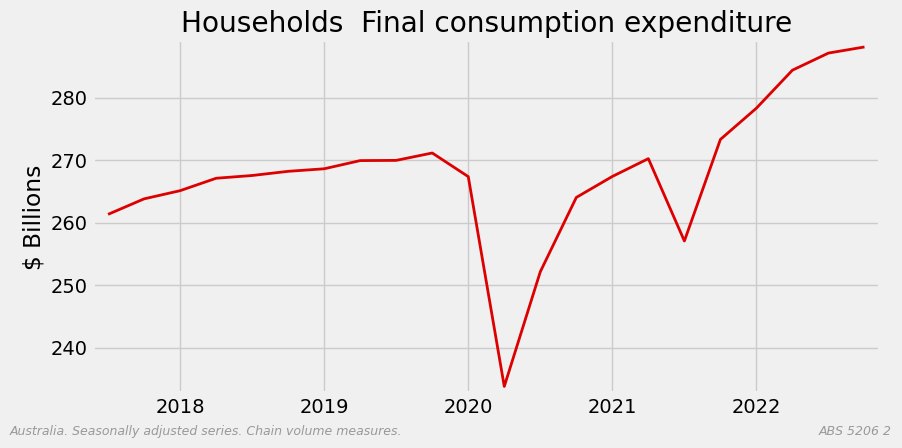

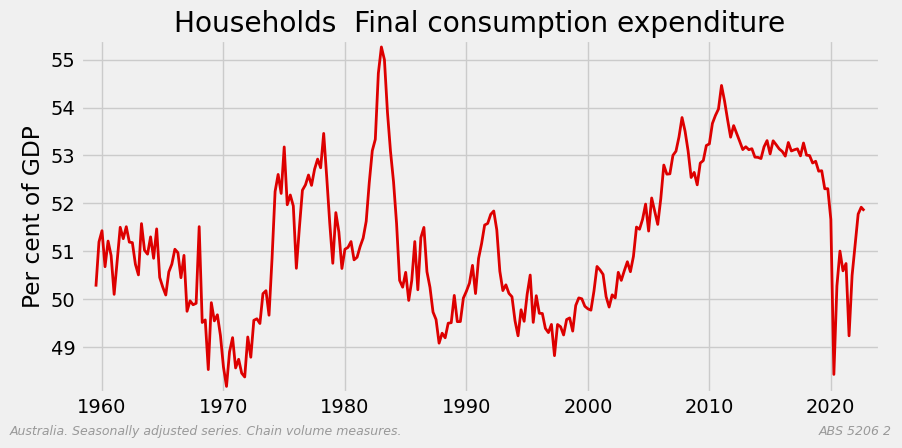

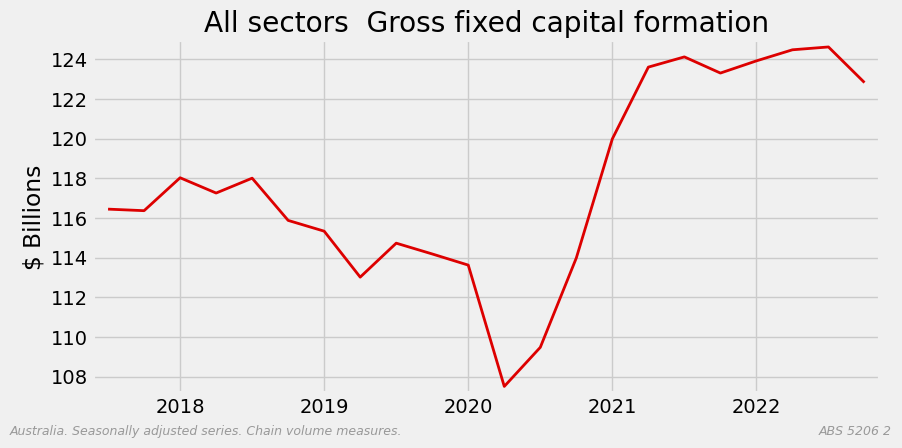

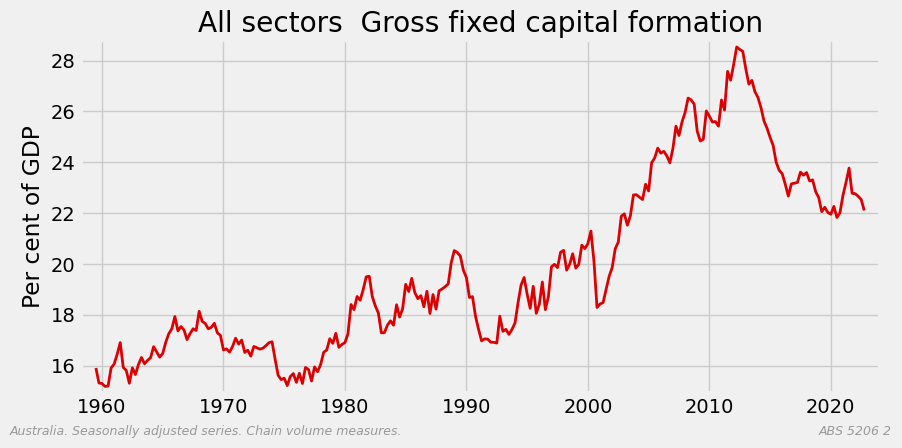

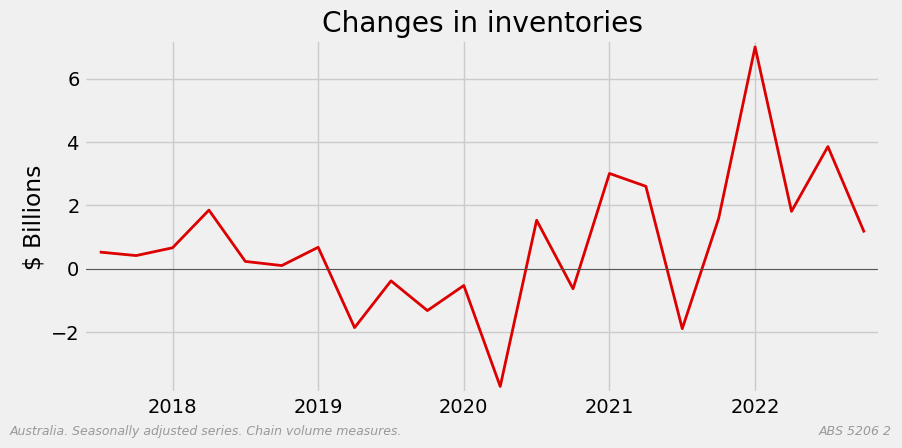

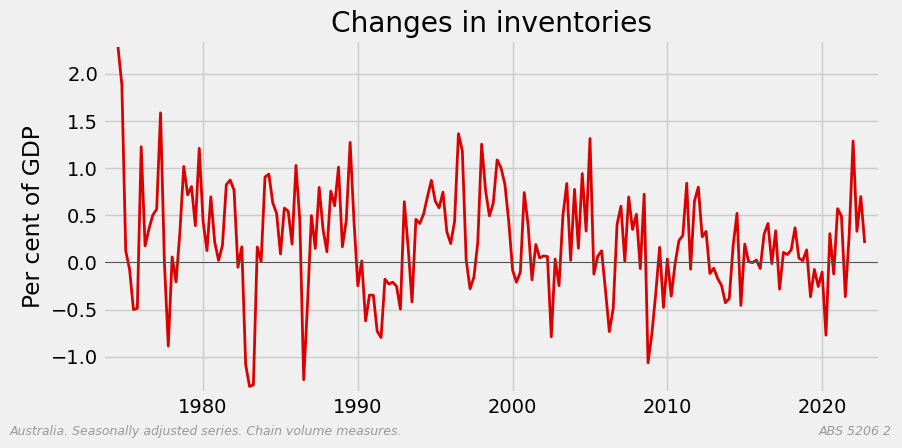

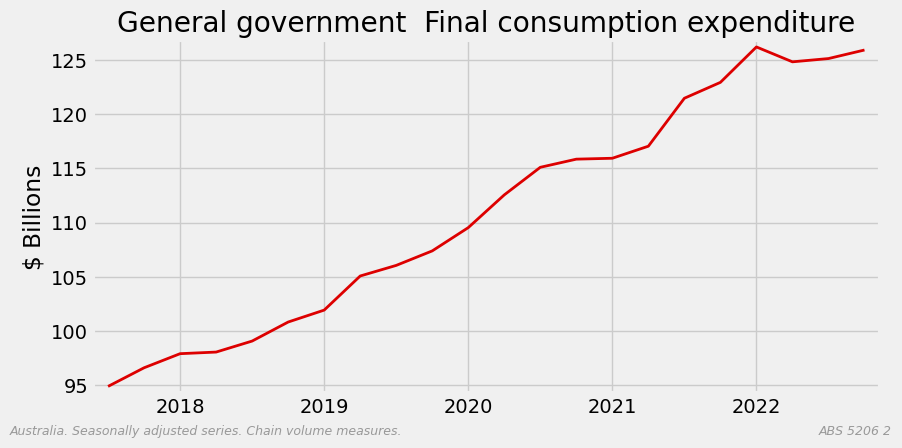

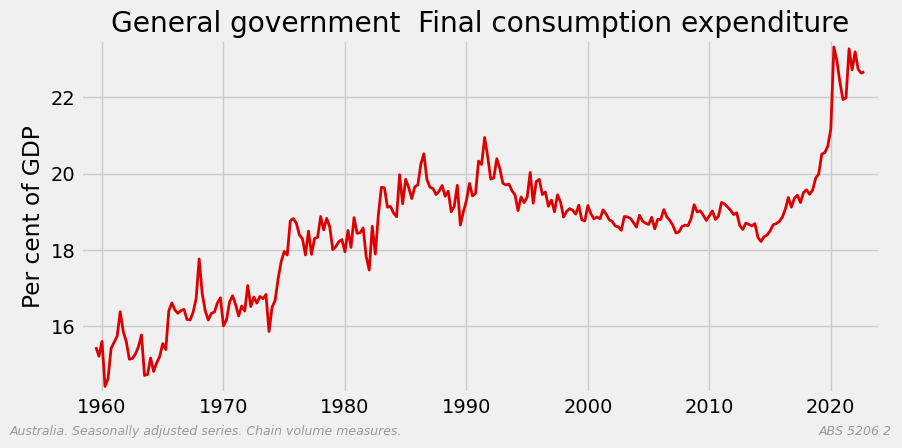

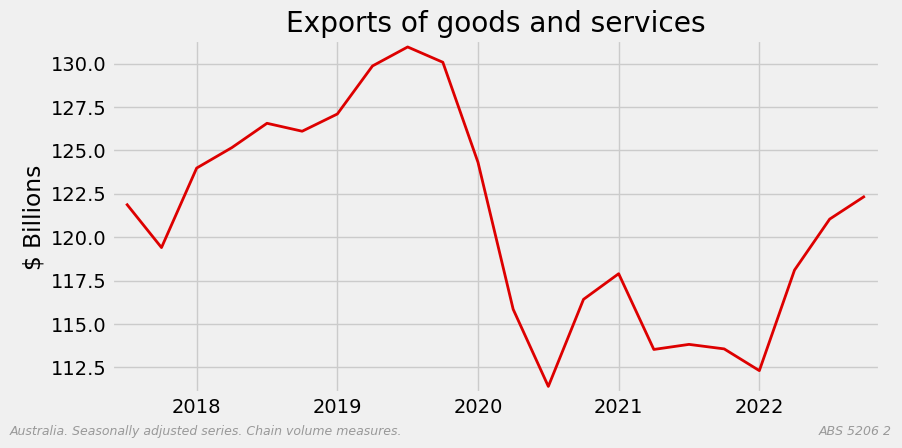

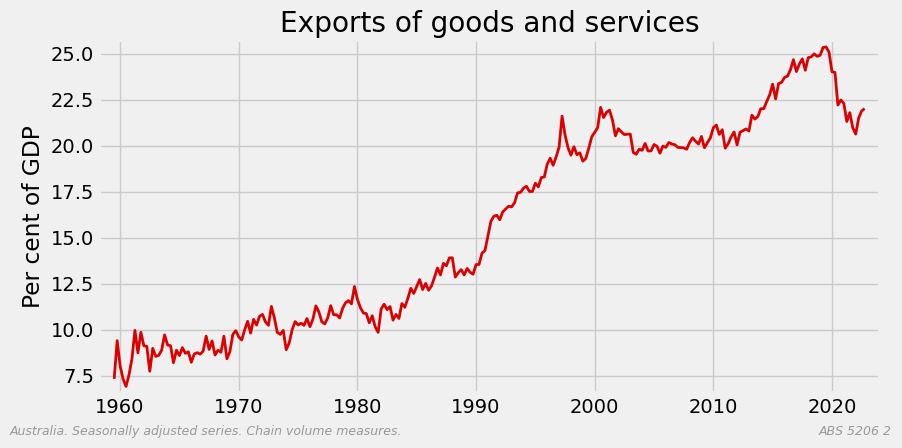

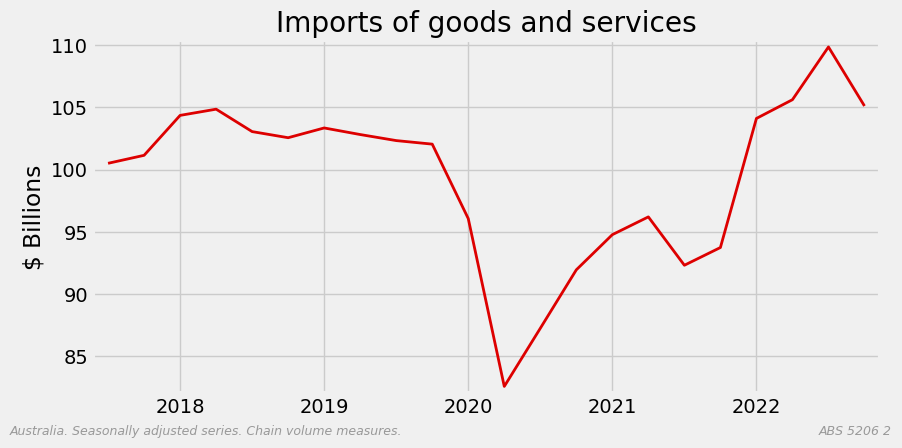

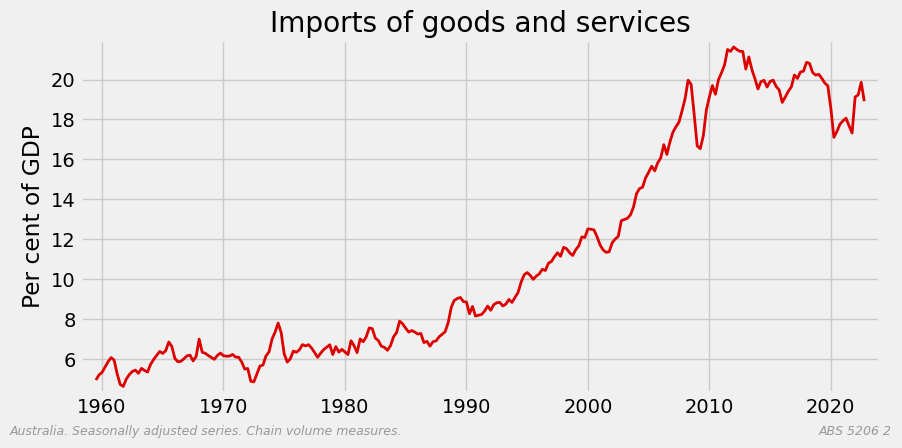

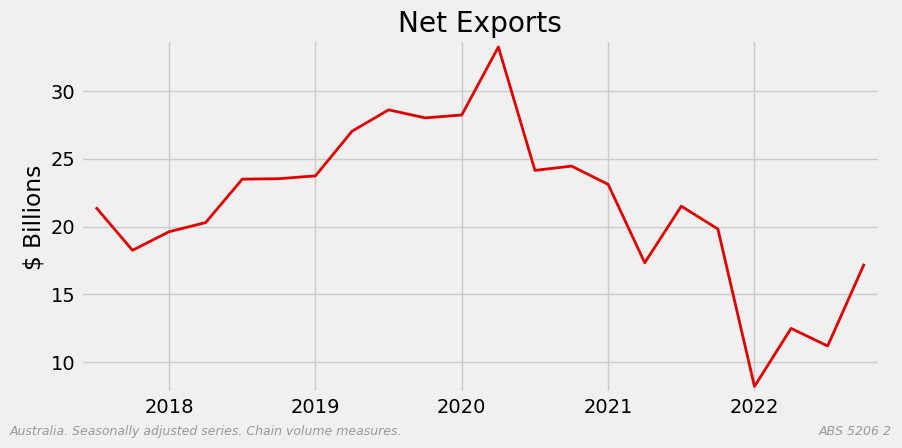

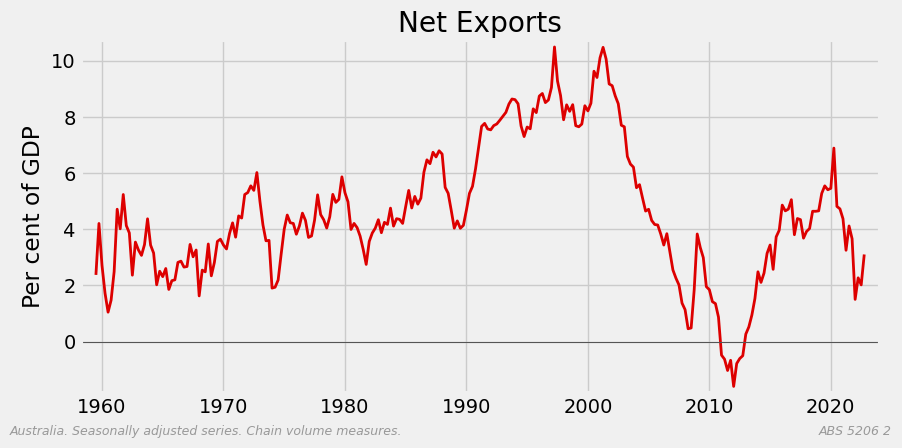

Index(['GDP', 'C', 'Invest', 'Invent', 'G', 'X'], dtype='object')


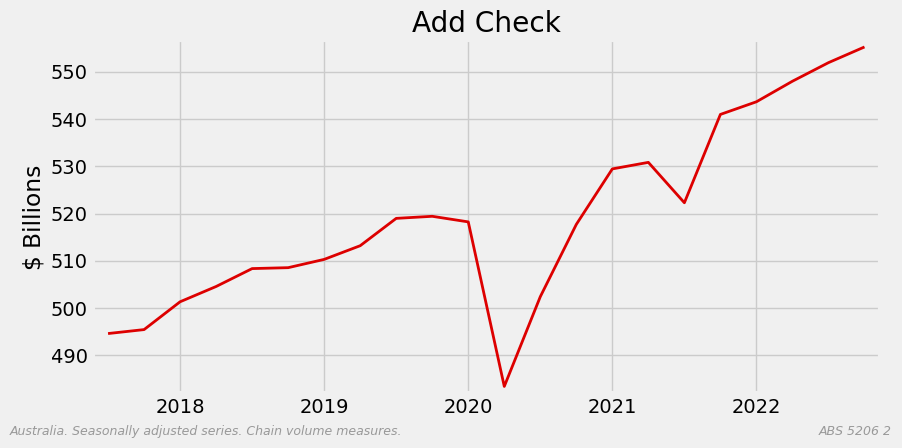

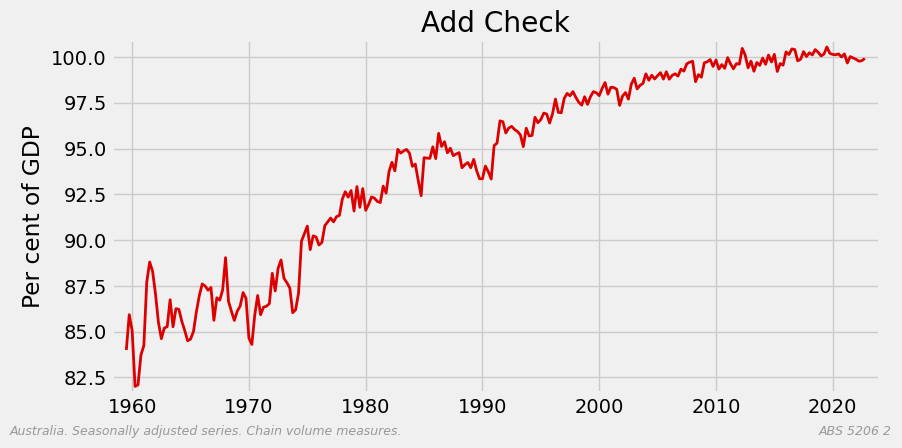

In [19]:
table = "2"
data = abs_dict[table]
components = {
    "GDP": "GROSS DOMESTIC PRODUCT ;",  # must be first
    "C": "Households ;  Final consumption expenditure ;",
    "Invest": "All sectors ;  Gross fixed capital formation ;",
    "Invent": "Changes in inventories ;",
    "G": "General government ;  Final consumption expenditure ;",
    "X": "Exports of goods and services ;",
    "M": "Imports of goods and services ;",
}
series_type = "Seasonally Adjusted"


gdp_exp_components = pd.DataFrame()
for component, did in components.items():
    id, units = get_identifier(meta, did, series_type, table)
    series, units = recalibrate_series(data[id], units)
    
    gdp_exp_components[component] = series
    if component == "GDP":
        gdp = gdp_exp_components[component]
        continue

    rfooter = f"{source} {table}"
    lfooter = f"Australia. {series_type.capitalize()} series. {CVM}."
    plot_gdp_series(series, units, did.replace(" ;", ""), rfooter, lfooter, gdp)

# net exports
ne = gdp_exp_components["X"] - gdp_exp_components["M"]
plot_gdp_series(ne, units, "Net Exports", rfooter, lfooter, gdp)

# Add check - this does not add - why???
everything = pd.DataFrame(gdp_exp_components)
print(everything.columns[:-1])
add_check = everything[everything.columns[1:-1]].sum(axis=1) - everything['M']
plot_gdp_series(add_check, units, "Add Check", rfooter, lfooter, gdp)

## Finished

In [20]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat Mar 11 2023 22:49:38

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

re        : 2.2.1
matplotlib: 3.7.1
numpy     : 1.24.2
pandas    : 1.5.3
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]

Watermark: 2.3.1



In [21]:
print("Finished")

Finished
